In [37]:
import os
import re
from glob import glob

import torch
import torch.optim as optim
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from tensorflow.core.util import event_pb2
# from tensorflow.python.lib.io import tf_record
# from tensorflow.python.framework import tensor_util

from source.models import gn_gan, sn_gan
from metrics.score.both import get_inception_score_and_fid

device = torch.device('cuda:0')

## Load model and evaluate FID and IS

In [38]:
z_dim = 128
batch_size = 128
root = "/mnt/data/backup/iccv21/logs"
cache_root = './.cache'
os.makedirs(cache_root, exist_ok=True)

content = [
    ("GN.RES.0", "GN-GAN_CIFAR10_RES_200k_0", gn_gan.ResGenerator32),
    ("GN.RES.1", "GN-GAN_CIFAR10_RES_200k_1", gn_gan.ResGenerator32),
    ("GN.RES.2", "GN-GAN_CIFAR10_RES_200k_2", gn_gan.ResGenerator32),
    ("GN.RES.3", "GN-GAN_CIFAR10_RES_200k_3", gn_gan.ResGenerator32),
    ("SN.RES.0", "SN-GAN_CIFAR10_RES_200k_0", sn_gan.ResGenerator32),
    ("SN.RES.1", "SN-GAN_CIFAR10_RES_200k_1", sn_gan.ResGenerator32),
    ("SN.RES.2", "SN-GAN_CIFAR10_RES_200k_2", sn_gan.ResGenerator32),
    ("SN.RES.3", "SN-GAN_CIFAR10_RES_200k_3", sn_gan.ResGenerator32),
]

fid_config = {
    'FID(train)': {
        'num_images': 50000,
        'fid_stats': './stats/cifar10.train.npz',
    },
    'FID(test)': {
        'num_images': 10000,
        'fid_stats': './stats/cifar10.test.npz',
    }
}
max_num_images = max([cfg['num_images'] for cfg in fid_config.values()])

with tqdm(content) as pbar:
    for legend_name, log_name, Generator in pbar:
        cache_path = os.path.join(cache_root, f'{legend_name}.eval.pt')
        if os.path.isfile(cache_path):
            pbar.write(f'Using cache {cache_path}')
        else:
            # initialize
            evaluation = {
                'IS': [],
                'IS_std': [],
                'step': [],
            }
            for cfg_name in fid_config.keys():
                evaluation[cfg_name] = []
            
            net_G = Generator(z_dim).to(device)
            ckpt_paths = list(glob(os.path.join(root, log_name, '*.pt')))
            ckpt_paths = list(filter(
                lambda p: re.compile(r'\d*.pt').match(os.path.basename(p)), ckpt_paths))
            ckpt_paths = sorted(
                ckpt_paths, key=lambda p: int(os.path.splitext(os.path.basename(p))[0]))
            # iterate checkpoints
            with tqdm(ckpt_paths, leave=False) as inner_bar:
                for ckpt_path in inner_bar:

                    # load model
                    evaluation['step'].append(int(os.path.splitext(os.path.basename(ckpt_path))[0]))
                    inner_bar.set_postfix_str(ckpt_path)
                    net_G.load_state_dict(torch.load(ckpt_path)['net_G'])
                    
                    # generate images
                    images = []
                    with torch.no_grad():
                        for _ in range(0, max_num_images, batch_size):
                            z = torch.randn(batch_size * 2, z_dim).to(device)
                            fake = (net_G(z) + 1) / 2
                            images.append(fake.cpu())
                    images = torch.cat(images, dim=0)

                    # evaluate with different settings
                    for cfg_name, cfg in fid_config.items():
                        (IS, IS_std), FID = get_inception_score_and_fid(
                            images[:cfg['num_images']], cfg['fid_stats'], verbose=False)
                        evaluation[cfg_name].append(FID)
                        if cfg_name == 'FID(train)':
                            evaluation['IS'].append(IS)
                            evaluation['IS_std'].append(IS_std)
            del net_G
            torch.save(evaluation, cache_path)

Using cache ./.cache/SN.RES.0.eval.pt
Using cache ./.cache/SN.RES.1.eval.pt
Using cache ./.cache/SN.RES.2.eval.pt
Using cache ./.cache/SN.RES.3.eval.pt



## Plot FID curve

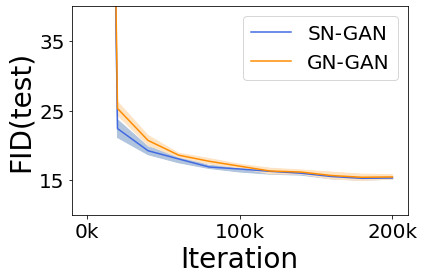

In [42]:
content = {
    'SN-GAN': {
        'cache_names': ("SN.RES.0", "SN.RES.1", "SN.RES.2", "SN.RES.3"),
        'color': 'royalblue',
        'fill': 'lightsteelblue',
    },
    'GN-GAN': {
        'cache_names': ("GN.RES.0", "GN.RES.1", "GN.RES.2", "GN.RES.3"),
        'color': 'darkorange',
        'fill': 'bisque',
    },
}
target = 'FID(test)'

ticks_fontsize = 20
label_fontsize = 28
legend_fontsize = 20

plt.figure(figsize=(6, 4))
for legend_name, cfg in content.items():
    fid_list = []
    step = None
    for cache_name in cfg['cache_names']:
        cache_path = os.path.join(cache_root, f'{cache_name}.eval.pt')
        evaluation = torch.load(cache_path)
        fid_list.append(evaluation[target])
        if step == None:
            step = evaluation['step']
        else:
            assert step == evaluation['step']
    fid = torch.tensor(fid_list)
    fid_mean = fid.mean(dim=0)
    fid_std = fid.std(dim=0)
#     plt.plot(loss['step'], loss[target], label=legend_name, linewidth=1.5, alpha=0.8)
    plt.plot(step, fid_mean, label=legend_name, color=cfg['color'])
    plt.fill_between(step, fid_mean + fid_std, fid_mean - fid_std, color=cfg['fill'])

xticks = [0, 100000, 200000]
xticks_label = ['%dk' % (x / 1000) for x in xticks]
plt.xticks(xticks, xticks_label, fontsize=ticks_fontsize)
plt.xlabel('Iteration', fontsize=label_fontsize)
# ax.tick_params(axis='x', labelsize=label_fontsize)

yticks = [15, 25, 35]
plt.ylim(10, 40)
plt.yticks(yticks, fontsize=ticks_fontsize)
plt.ylabel(target, fontsize=label_fontsize)

plt.legend(fontsize=legend_fontsize)
plt.tight_layout()
plt.savefig('./figures/vis_fid_of_resnets.png')
plt.show()

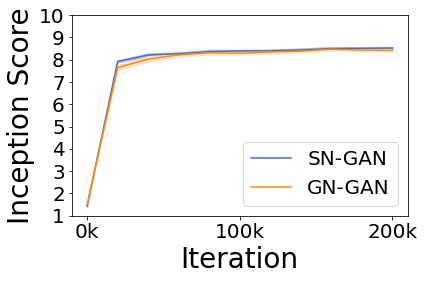

In [40]:
content = {
    'SN-GAN': {
        'cache_names': ("SN.RES.0", "SN.RES.1", "SN.RES.2", "SN.RES.3"),
        'color': 'royalblue',
        'fill': 'lightsteelblue',
    },
    'GN-GAN': {
        'cache_names': ("GN.RES.0", "GN.RES.1", "GN.RES.2", "GN.RES.3"),
        'color': 'darkorange',
        'fill': 'bisque',
    },
}
target = 'IS'

ticks_fontsize = 20
label_fontsize = 28
legend_fontsize = 20

plt.figure(figsize=(6, 4))
for legend_name, cfg in content.items():
    fid_list = []
    step = None
    for cache_name in cfg['cache_names']:
        cache_path = os.path.join(cache_root, f'{cache_name}.eval.pt')
        evaluation = torch.load(cache_path)
        fid_list.append(evaluation[target])
        if step == None:
            step = evaluation['step']
        else:
            assert step == evaluation['step']
    fid = torch.tensor(fid_list)
    fid_mean = fid.mean(dim=0)
    fid_std = fid.std(dim=0)
#     plt.plot(loss['step'], loss[target], label=legend_name, linewidth=1.5, alpha=0.8)
    plt.plot(step, fid_mean, label=legend_name, color=cfg['color'])
    plt.fill_between(step, fid_mean + fid_std, fid_mean - fid_std, color=cfg['fill'])

xticks = [0, 100000, 200000]
xticks_label = ['%dk' % (x / 1000) for x in xticks]
plt.xticks(xticks, xticks_label, fontsize=ticks_fontsize)
plt.xlabel('Iteration', fontsize=label_fontsize)
# ax.tick_params(axis='x', labelsize=label_fontsize)

# yticks = [15, 25, 35]
plt.ylim(1, 10)
plt.yticks(fontsize=ticks_fontsize)
plt.ylabel('Inception Score', fontsize=label_fontsize)

plt.legend(fontsize=legend_fontsize)
plt.tight_layout()
plt.savefig('./figures/vis_inceptionscore_of_resnets.png')
plt.show()

## Retrieve loss from tf.record

In [41]:
z_dim = 128
batch_size = 128
root = "/mnt/data/backup/iccv21/logs"
cache_root = './.cache'
os.makedirs(cache_root, exist_ok=True)
content = [
    ("GN.RES.0", "GN-GAN_CIFAR10_RES_0"),
    ("GN.RES.1", "GN-GAN_CIFAR10_RES_1"),
    ("GN.RES.2", "GN-GAN_CIFAR10_RES_2"),
    ("GN.RES.3", "GN-GAN_CIFAR10_RES_3"),
    ("SN.RES.0", "SN-GAN_CIFAR10_RES_200k_0"),
    ("SN.RES.1", "SN-GAN_CIFAR10_RES_200k_1"),
    ("SN.RES.2", "SN-GAN_CIFAR10_RES_200k_2"),
    ("SN.RES.3", "SN-GAN_CIFAR10_RES_200k_3"),
]

def summary_iterator(dir_path):
    for path in glob(os.path.join(dir_path, '*')):
        if 'events.out.tfevents' in path:
            break
    else:
        raise ValueError("%s is not a log directory" % dir_path)
    try:
        for r in tf.data.TFRecordDataset(path):
            yield event_pb2.Event.FromString(r.numpy())
    except tf.errors.DataLossError:
        return

with tqdm(content) as pbar:
    for legend_name, dir_name in pbar:
        
        cache_path = os.path.join(cache_root, f'{legend_name}.loss.pt')
        if os.path.isfile(cache_path):
            pbar.write(f'Using cache {cache_path}')
        else:
            loss = {
                'loss': [],
                'loss_real': [],
                'loss_fake': [],
                'step': [],
            }
            pbar.set_description(legend_name)
            dir_path = os.path.join(root, dir_name)
            for event in summary_iterator(dir_path):
                for value in event.summary.value:
                    if value.tag in ["loss", "loss_real", "loss_fake"]:
                        loss[value.tag].append(value.simple_value)
                        if value.tag == 'loss':
                            loss['step'].append(event.step)
            torch.save(loss, cache_path)
        

Using cache ./.cache/GN.RES.0.loss.pt
Using cache ./.cache/GN.RES.1.loss.pt
Using cache ./.cache/GN.RES.2.loss.pt
Using cache ./.cache/GN.RES.3.loss.pt
Using cache ./.cache/SN.RES.0.loss.pt
Using cache ./.cache/SN.RES.1.loss.pt
Using cache ./.cache/SN.RES.2.loss.pt
Using cache ./.cache/SN.RES.3.loss.pt



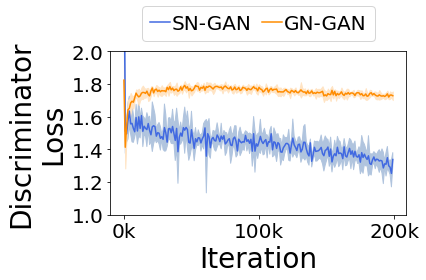

In [29]:
content = {
    'SN-GAN': {
        'cache_names': ("SN.RES.0", "SN.RES.1", "SN.RES.2", "SN.RES.3"),
        'color': 'royalblue',
        'fill': 'lightsteelblue',
    },
    'GN-GAN': {
        'cache_names': ("GN.RES.0", "GN.RES.1", "GN.RES.2", "GN.RES.3", "GN.RES.4"),
        'color': 'darkorange',
        'fill': 'bisque',
    },
}
target = 'loss'

ticks_fontsize = 20
label_fontsize = 28
legend_fontsize = 20
sample_indexs = torch.arange(0, 200000, 1000)

plt.figure(figsize=(6, 4))
for legend_name, cfg in content.items():
    loss_list = []
    step = None
    for cache_name in cfg['cache_names']:
        cache_path = os.path.join(cache_root, f'{cache_name}.loss.pt')
        loss = torch.load(cache_path)
        loss_list.append(loss['loss'])
        if step == None:
            step = loss['step']
        else:
            assert step == loss['step']
    loss = torch.tensor(loss_list)
    loss = loss[:, sample_indexs]
    step = torch.tensor(step)[sample_indexs]
    loss_mean = loss.mean(dim=0)
    loss_std = loss.std(dim=0)
    plt.plot(step, loss_mean, label=legend_name, color=cfg['color'])
    plt.fill_between(step, loss_mean + loss_std, loss_mean - loss_std, color=cfg['fill'])

xticks = [0, 100000, 200000]
xticks_label = ['%dk' % (x / 1000) for x in xticks]
plt.xticks(xticks, xticks_label, fontsize=ticks_fontsize)
plt.xlabel('Iteration', fontsize=label_fontsize)
# ax.tick_params(axis='x', labelsize=label_fontsize)

# yticks = [15, 25, 35]
plt.ylim(1, 2)
plt.yticks(fontsize=ticks_fontsize)
plt.ylabel('Discriminator\nLoss', fontsize=label_fontsize)

plt.legend(
    loc='lower center', fontsize=legend_fontsize,
    ncol=3, columnspacing=0.5, handlelength=1.0, handletextpad=0.1,
    bbox_to_anchor=(0.5, 1))
# plt.legend(fontsize=legend_fontsize, handlelength=1.0)
plt.tight_layout()
plt.savefig('./figures/vis_loss_of_resnets.png')
plt.show()